# Instructions
In this assingment, you will be creating your very own trading algorithim by using signals to determine when you should buy or sell a stock. The goal of this assignment is to see your capabilities in coding. In the first part of the assignment, you will be writing the code for the RSI signal and another signal of your own choice. In the second part, you will use these signals to buy or sell the stock. At the end, we will see how much money you have made. 

# Step 1

Download the following packages (just run the boxes below). Do not change the code below. Note that we will be using an API package to download data from yahoo. The data is in dataframe format. You will be given the  High Price, Low Price, Close Price, Adjusted Close Price, and Volume of the stock traded on a particular day. Your task is to use the data to generate signals, which can be used to determine when to buy or sell the stock. 

In [1]:
pip install yahoo_historical

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime
import pandas as pd

In [3]:
ticker = "GILD"
from yahoo_historical import Fetcher
data = Fetcher(ticker, [2010,1,4], [2019,6,14])
data = data.getHistorical()

In [4]:
from datetime import datetime
date_object = datetime.strptime(data.iloc[0, 0], "%Y-%m-%d")
for x in data.index[:]:
    data.iloc[x,0] = datetime.strptime(data.iloc[x,0], "%Y-%m-%d")

# Step 2
In this step, you will be coding the RSI signal along with an additional signal of your choice. RSI readings range from 0 to 100, with readings above 70 generally interpreted as indicating overbought conditions and readings below 30 indicating oversold conditions. When deciding which other signal to choose, try to consider which signal would go well with the RSI signal. 

Please try to give plenty of comments. Also use the adjusted closing price in the data when calculating for RSI and the second signal.

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04 00:00:00,21.695,21.860001,21.545000,21.650000,19.142828,16809000
1,2010-01-05 00:00:00,21.680,21.705000,21.350000,21.629999,19.125145,20788200
2,2010-01-06 00:00:00,22.000,22.504999,21.805000,22.379999,19.788288,32750400
3,2010-01-07 00:00:00,22.375,22.575001,22.280001,22.434999,19.836914,20892600
4,2010-01-08 00:00:00,22.480,22.549999,22.125000,22.270000,19.691031,17618400


In [6]:
#define the rsi_signal
def RSI(data, period):
    #Create a series of the difference between the current price with the day before.
    Diff = data['Adj Close'].diff()

    #Separate the series into gain, which has +diff and loss for -diff.
    Gain = Diff[Diff >= 0]
    Loss = Diff[Diff <= 0]
    data['Gain'] = Gain
    data['Loss'] = Loss

    #Fill all of the NaN value with 0
    data.fillna(0, inplace = True)

    #Search for the mean in certain period above
    RolGain = data['Gain'].rolling(period).mean()
    RolLoss = data['Loss'].rolling(period).mean().abs()

    #Use the formula to calculate the RSI
    RS = RolGain / RolLoss
    rsi = 100.0 - (100.0 / (1.0 + RS))
    data['RSI'] = rsi
    data['RSI'].fillna(50, inplace = True)
    return data['RSI']

In [7]:
#define second_signal
def MACD(data, slow, fast, signal):
    
    #Create a Slow EMA from SMA
    c = 2 / float(slow + 1)
    data['SlowSMA'] = data['Adj Close'].rolling(slow).mean()
    data['SlowEMA'] = (c * data['Adj Close']) + ((1 - c) * data['SlowSMA'])

    #Create fast EMA
    c = 2 / float(fast + 1)
    data['FastSMA'] = data['Adj Close'].rolling(fast).mean()
    data['FastEMA'] = (c * data['Adj Close']) + ((1 - c) * data['FastSMA'])

    #Create EMA for the signal line
    c = 2 / float(signal + 1)
    data['SignalSMA'] = data['Adj Close'].rolling(signal).mean()
    data['SignalEMA'] = (c * data['Adj Close']) + ((1 - c) * data['SignalSMA'])

    # Signal Line
    data['SignalLine'] = data['SignalEMA'] - data['SlowEMA']

    # MACD Line
    data["MACDLine"] = data['FastEMA'] - data['SlowEMA']

    # MACD Indicator
    data["MACD"] = data["MACDLine"] - data['SignalLine']
    
    #Fill the NaN value on the several first row with the one below
    data["MACD"].fillna(method = 'bfill', inplace = True)
    
    return data["MACD"]

# Step 3
After finishing step 2, you can now create your own trading algorithim. The singals you have created should be used in this part. The output of the signals may be an array of values, which you may use to determine if you should buy the stock or not. You may assume that you can only make a trade after the market has closed. 

In [8]:
#signal1 = RSI(data, period)
#signal2 = second_signal(data, period)

#Use the default RSI
signal1 = RSI(data, 14)

#Use the default MACD, but weekly
signal2 = MACD(data, 26*5, 12*5, 9*5)

#Create trades array and Stocks in hand variable
trades = []
stocks = 0


#Sample, if the value in signal 1 meets condition 
#and if the value in signal 2 meets condition then buy or sell 

for i in range(len(signal2)):
    #Buy when RSI is oversold and Sell when overbought
    buy_cond1 = signal1[i] <= 30
    sell_cond1 = signal1[i] >= 70
    
    #Buy when MACD histogram is negative with a rising gradient and Sell when the histogram is positive with dropping gradient
    buy_cond2 = (signal2[i] < 0) and (np.gradient(signal2)[i] >= 0)
    sell_cond2 = (signal2[i] > 0) and (np.gradient(signal2)[i] <= 0)
    
    #Insert -1 to the array when there is stock in hand and fulfill the sell condition
    if (stocks > 0) and (sell_cond1 or sell_cond2) :
        trades.append(-1)
        stocks -= 1
    
    #Inset 1 to the array when fulfill the buy condition
    elif (buy_cond1 or buy_cond2):
        trades.append(1)
        stocks += 1
    
    #Do not do anything otherwise
    else:
        trades.append(0)



#for each trading day you can buy, sell, or do nothing
#your output should be an an array with a size equal the number of trading days
#if you buy in a day, then the value in array should be 1
#if you sell in a day, then the value in array should be -1 
#if you do nothing in a day, then the value in array should be 0
#call the array trades

If your code does not run, you will get a zero. We will not debug your code. I hope you have a fun time. 

# Evaluation of Algorithim
We have created a compute_pnl() and compute performance() function to calculate the overall profitability and performance of your trading strategy. Please do not change the underlying code. Also add the details of your performance to your report. Please include the charts that have been generated below. Note each trade costs $0.1. Also at the end of the period, all unsettled positions will be liquidated based on the final closing price of the stock. 


In [9]:
def compute_pnl(long, short, r_pnl, data, day):
    d_pnl = r_pnl
    if long:
        for x in long:
            d_pnl = d_pnl + data.iloc[day, 5] - x
    else:
        for x in short:
            d_pnl = d_pnl + x - data.iloc[day, 5]
    
    return d_pnl

In [10]:
from collections import deque
import statistics
def compute_performance(x):
    long = deque()
    short = deque()
    
    r_pnl = 0
    realized_pnl = []
    d_pnl = 0
    daily_pnl = []
    
    num_long_positions = 0;
    num_short_positions = 0;
    long_position = []
    short_position = []

    for day in data.index[:]:
        if trades[day] == -1:
            if long:
                r_pnl = r_pnl + data.iloc[day,5]- long[0] - 0.1
                long.popleft()
                num_long_positions = num_long_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                short.append(data.iloc[day,5]) 
                num_short_positions = num_short_positions + 1
        
        elif trades[day] == 1:
            if short:
                r_pnl = r_pnl + short[0] - data.iloc[day,5] - 0.1
                short.popleft()
                num_short_positions = num_short_positions - 1
            else :
                r_pnl = r_pnl - 0.1
                long.append(data.iloc[day,5])
                num_long_positions = num_long_positions + 1
        else :
            pass
        
        daily_pnl.append(compute_pnl(long, short, r_pnl, data, day))
        realized_pnl.append(r_pnl)
        long_position.append(num_long_positions)
        short_position.append(num_short_positions)
        
    while long:
        r_pnl = r_pnl + data.iloc[-1,5] - long[0] - 0.1
        long.popleft()
        num_long_positions = num_long_positions - 1 
        
    while short:
        r_pnl = r_pnl + short[0] - data.iloc[-1,5]  - 0.1
        short.popleft()
        num_short_positions = num_short_positions - 1
    
    daily_pnl.append(r_pnl)
    realized_pnl.append(r_pnl)
    long_position.append(num_long_positions)
    short_position.append(num_short_positions)
        
    return r_pnl, realized_pnl, daily_pnl, long_position, short_position


In [11]:
r_pnl, realized_pnl, daily_pnl, long_position, short_position = compute_performance(trades)

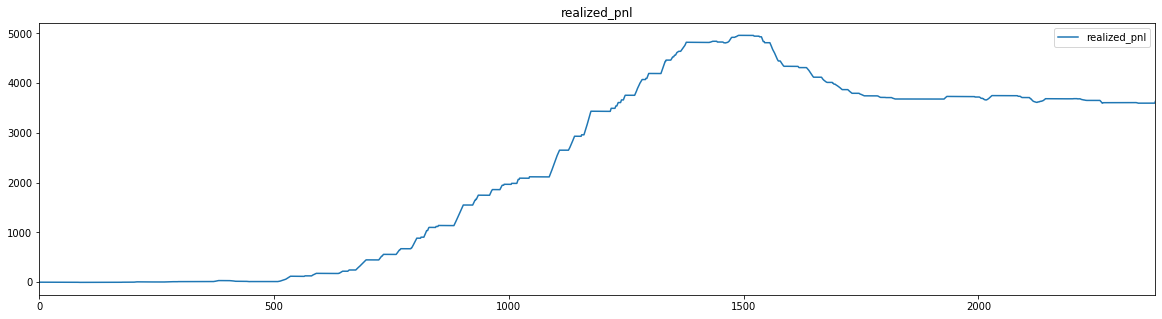

In [12]:
realized_pnl_df = pd.DataFrame(realized_pnl, columns = ["realized_pnl"])
realized_pnl_df.plot(figsize = (20,5))
plt.title("realized_pnl")
plt.show()

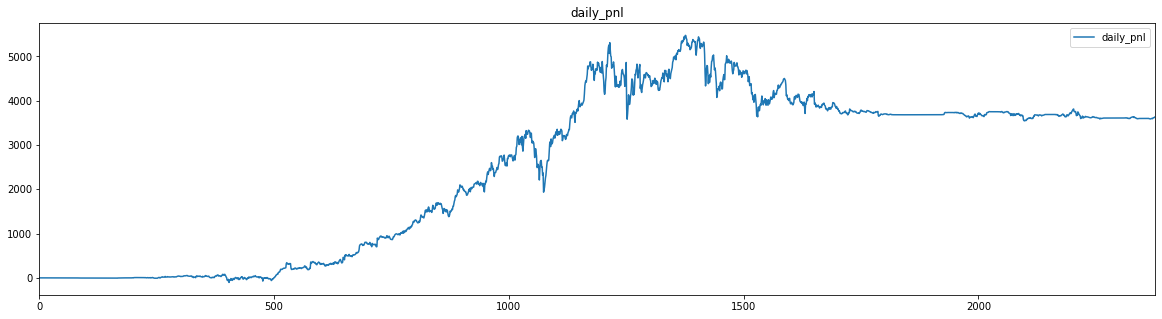

total earnings 3630.332149999965
stdev: 1787.9436516819303


In [13]:
daily_pnl_df = pd.DataFrame(daily_pnl, columns = ["daily_pnl"])
daily_pnl_df.plot(figsize = (20,5))
plt.title("daily_pnl")
plt.show()
print("total earnings " + str(r_pnl))
print("stdev: " + str(statistics.stdev(daily_pnl)))

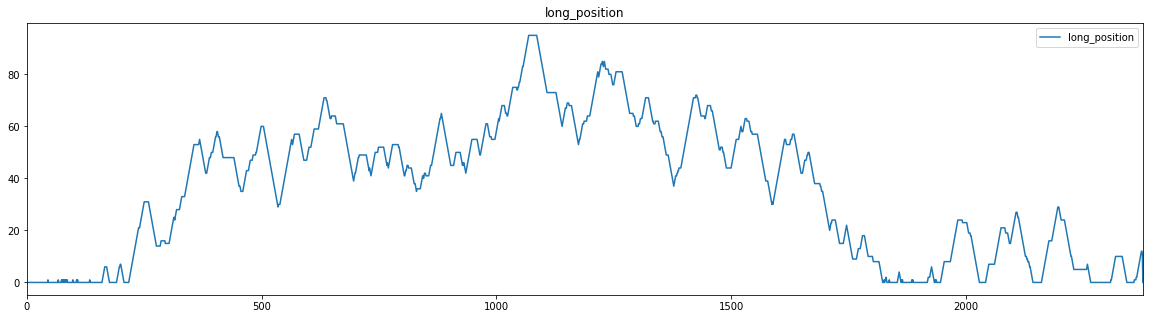

In [14]:
long_position_df = pd.DataFrame(long_position, columns = ["long_position"])
long_position_df.plot(figsize = (20,5))
plt.title("long_position")
plt.show()

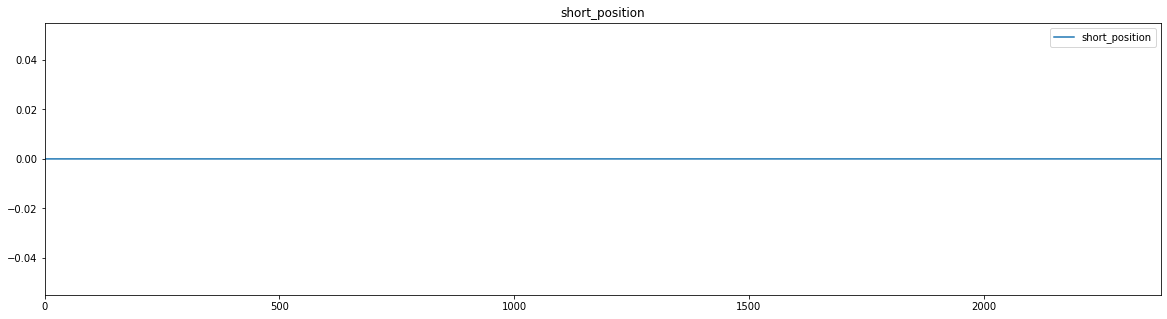

In [15]:
short_position_df = pd.DataFrame(short_position, columns = ["short_position"])
short_position_df.plot(figsize = (20,5))
plt.title("short_position")
plt.show()

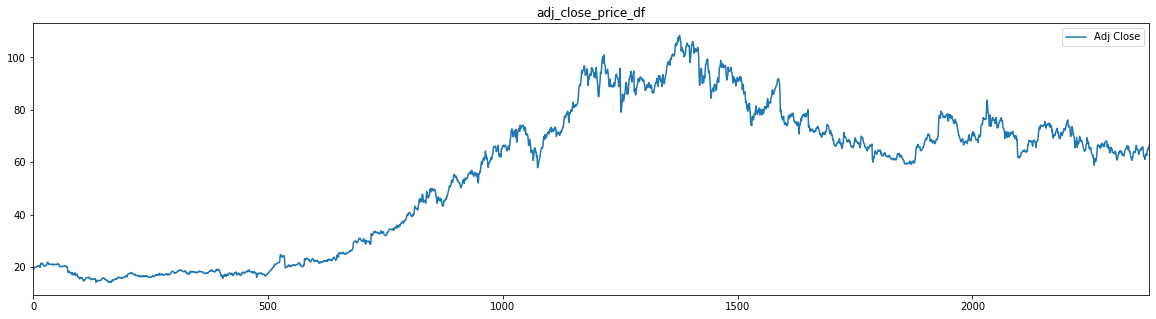

In [16]:
adj_close_price_df = pd.DataFrame(data.iloc[:,5])
adj_close_price_df.plot(figsize = (20,5))
plt.title("adj_close_price_df")
plt.show()